# 1. Load CWRU Dataset

This notebook implements Experiment A inspired by the reference paper, focusing on the impact of feature representation on anomaly detectability.

We keep the anomaly detector fixed (Isolation Forest) and vary the feature sets:
- A: Time-domain features
- B: Frequency-domain (FFT) features
- C: Time + Frequency features

We train on healthy data only and evaluate on a mixed set (healthy + faulty).

Dataset: Case Western Reserve University (CWRU) Bearing Data Center.


In [ ]:
from __future__ import annotations

import os
import glob
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np

# Optional dependencies (recommended):
# pip install scipy pandas scikit-learn matplotlib
from scipy.io import loadmat


@dataclass
class CWRURecord:
    """
    Container for one raw vibration signal and its metadata.

    Attributes
    ----------
    signal : np.ndarray
        1D vibration signal (time series).
    label : int
        0 for healthy, 1 for faulty.
    condition : str
        Human-readable condition name (e.g., "healthy", "IR_007", "OR_021").
    filename : str
        Source file name.
    sampling_rate_hz : int
        Sampling rate (Hz). Many CWRU subsets use 12000 Hz or 48000 Hz.
        If not available in the file, set it in the configuration.
    """
    signal: np.ndarray
    label: int
    condition: str
    filename: str
    sampling_rate_hz: int


def _extract_1d_signal_from_mat(mat: dict) -> np.ndarray:
    """
    Heuristic extractor for the vibration time-series from a CWRU .mat dict.

    CWRU files often contain keys like:
      - 'X097_DE_time', 'X097_FE_time', etc.
    We select a time-domain channel (preferably DE) by searching for known patterns.

    """
    # Candidate keys ordered by preference (drive-end time channel first)
    preferred_key_substrings = ["DE_time", "FE_time", "_time"]

    keys = [k for k in mat.keys() if not k.startswith("__")]
    # Try to find a key that matches preferred patterns
    for sub in preferred_key_substrings:
        candidates = [k for k in keys if sub in k]
        if candidates:
            # Pick the first candidate deterministically
            k = sorted(candidates)[0]
            arr = mat[k]
            # CWRU arrays may come as shape (N, 1) or (1, N)
            x = np.asarray(arr).squeeze()
            if x.ndim != 1:
                raise ValueError(f"Extracted signal is not 1D. Key={k}, shape={x.shape}")
            return x.astype(np.float32)

    raise ValueError(
        "Could not find a suitable time-domain channel in .mat file. "
        "Please inspect the file keys and adapt _extract_1d_signal_from_mat()."
    )


def load_cwru_from_folder(
    root_dir: str,
    file_glob: str = "*.mat",
    sampling_rate_hz_default: int = 12000,
    label_rules: Optional[Dict[str, Tuple[int, str]]] = None,
) -> List[CWRURecord]:
    """
    Load CWRU .mat files from a folder and assign labels/conditions via filename rules.

    Parameters
    ----------
    root_dir : str
        Folder containing CWRU .mat files.
    file_glob : str
        Glob pattern for files.
    sampling_rate_hz_default : int
        Default sampling rate used if not known per file.
    label_rules : dict or None
        Mapping from substring -> (label, condition_name).
        Example:
            {
              "healthy": (0, "healthy"),
              "normal": (0, "healthy"),
              "IR": (1, "IR"),
              "OR": (1, "OR"),
              "B": (1, "BA"),
            }
        You should adapt rules to how your file names are structured.

    Returns
    -------
    records : list[CWRURecord]
        Loaded records.
    """
    if label_rules is None:
        # Minimal default rules; you should adapt to your local naming convention.
        label_rules = {
            "normal": (0, "healthy"),
            "healthy": (0, "healthy"),
            "IR": (1, "faulty"),
            "OR": (1, "faulty"),
            "BA": (1, "faulty"),
        }

    paths = sorted(glob.glob(os.path.join(root_dir, file_glob)))
    if not paths:
        raise FileNotFoundError(
            f"No files found in {root_dir} with pattern {file_glob}. "
            "Please download the CWRU dataset and point root_dir to the folder."
        )

    records: List[CWRURecord] = []
    for p in paths:
        mat = loadmat(p)
        x = _extract_1d_signal_from_mat(mat)

        fname = os.path.basename(p)
        label, condition = 1, "faulty"
        for sub, (lab, cond) in label_rules.items():
            if sub.lower() in fname.lower():
                label, condition = lab, cond
                break

        records.append(
            CWRURecord(
                signal=x,
                label=label,
                condition=condition,
                filename=fname,
                sampling_rate_hz=sampling_rate_hz_default,
            )
        )

    return records


In [3]:
# ---------------------------------------------------------
# Dataset loading and initial sanity checks
# ---------------------------------------------------------

# 1) Define dataset location
# Recommended structure:
#   <repo_root>/data/cwru/raw/*.mat
root_dir = r"../../data/cwru/raw"   # Windows-friendly relative path
file_glob = "*.mat"

# 2) Baseline sampling rate (aligned with most CWRU literature)
fs_hz = 12000

# 3) Labeling rules based on filename patterns
# IMPORTANT: adapt this mapping to your local file naming convention
label_rules = {
    "normal": (0, "healthy"),
    "healthy": (0, "healthy"),
    "ir": (1, "faulty"),   # inner race fault
    "or": (1, "faulty"),   # outer race fault
    "ba": (1, "faulty"),   # ball fault
    "b": (1, "faulty"),    # some datasets use 'B' for ball fault
}

# 4) Load dataset
records = load_cwru_from_folder(
    root_dir=root_dir,
    file_glob=file_glob,
    sampling_rate_hz_default=fs_hz,
    label_rules=label_rules,
)

print(f"Total files loaded: {len(records)}")

n_healthy = sum(r.label == 0 for r in records)
n_faulty = sum(r.label == 1 for r in records)

print(f"Healthy files: {n_healthy}")
print(f"Faulty files:  {n_faulty}")

# 5) Basic signal length statistics
lengths = np.array([len(r.signal) for r in records], dtype=np.int64)

print("Signal length statistics (in samples):")
print(f"  min:    {lengths.min()}")
print(f"  median: {int(np.median(lengths))}")
print(f"  max:    {lengths.max()}")

# 6) Inspect a few records to validate labeling logic
print("\nSample records:")
for r in records[:5]:
    print(
        f"{r.filename:40s} | "
        f"label={r.label} | "
        f"condition={r.condition:8s} | "
        f"fs={r.sampling_rate_hz} | "
        f"N={len(r.signal)}"
    )


Total files loaded: 40
Healthy files: 4
Faulty files:  36
Signal length statistics (in samples):
  min:    121265
  median: 121991
  max:    485643

Sample records:
B007_0.mat                               | label=1 | condition=faulty   | fs=12000 | N=122571
B007_1.mat                               | label=1 | condition=faulty   | fs=12000 | N=121410
B007_2.mat                               | label=1 | condition=faulty   | fs=12000 | N=121556
B007_3.mat                               | label=1 | condition=faulty   | fs=12000 | N=121556
B014_0.mat                               | label=1 | condition=faulty   | fs=12000 | N=121846


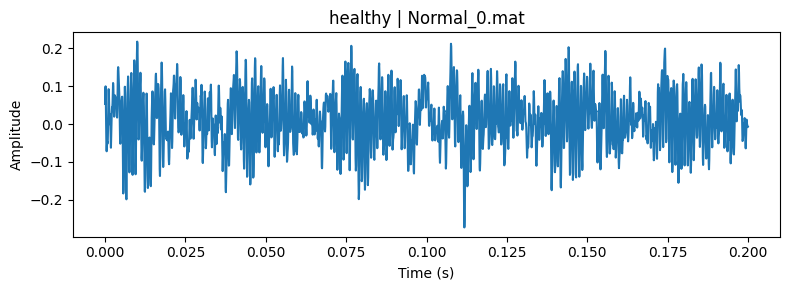

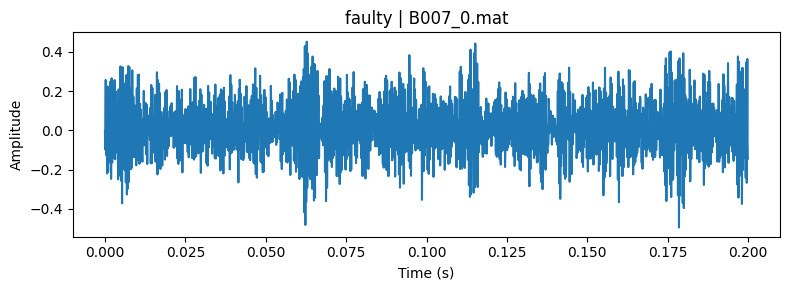

In [4]:
import matplotlib.pyplot as plt

def plot_signal_segment(
    record: CWRURecord,
    duration_sec: float = 0.2,
    start_sec: float = 0.0,
) -> None:
    """
    Plot a short time-domain segment from a CWRU record for visual inspection.
    """
    fs = record.sampling_rate_hz
    start = int(start_sec * fs)
    end = min(start + int(duration_sec * fs), len(record.signal))

    segment = record.signal[start:end]
    t = np.arange(len(segment)) / fs

    plt.figure(figsize=(8, 3))
    plt.plot(t, segment)
    plt.title(f"{record.condition} | {record.filename}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


# Plot one healthy and one faulty example (if available)
healthy_records = [r for r in records if r.label == 0]
faulty_records = [r for r in records if r.label == 1]

if healthy_records:
    plot_signal_segment(healthy_records[0])

if faulty_records:
    plot_signal_segment(faulty_records[0])


## Semantic validation

In [8]:
from collections import Counter

# Count by condition
condition_counts = Counter(r.condition for r in records)
label_counts = Counter(r.label for r in records)

print("Counts by condition:")
for k, v in condition_counts.items():
    print(f"  {k:10s}: {v}")

print("\nCounts by label:")
for k, v in label_counts.items():
    name = "healthy" if k == 0 else "faulty"
    print(f"  {name:8s}: {v}")



Counts by condition:
  faulty    : 36
  healthy   : 4

Counts by label:
  faulty  : 36
  healthy : 4


### Note 1:
The CWRU dataset contains a limited number of healthy runs compared to faulty conditions. While this provides sufficient window-level samples for training, it may limit the diversity of the learned normal behavior.

In [9]:
def basic_signal_stats(x: np.ndarray) -> dict:
    return {
        "mean": float(np.mean(x)),
        "std": float(np.std(x)),
        "rms": float(np.sqrt(np.mean(x**2))),
        "kurtosis": float(np.mean((x - np.mean(x))**4) / (np.std(x)**4 + 1e-12)),
    }

healthy_stats = []
faulty_stats = []

for r in records:
    stats = basic_signal_stats(r.signal[:fs_hz * 2])  # first 2 seconds
    if r.label == 0:
        healthy_stats.append(stats)
    else:
        faulty_stats.append(stats)

import pandas as pd

df_healthy = pd.DataFrame(healthy_stats)
df_faulty = pd.DataFrame(faulty_stats)

print("Healthy (mean of stats):")
print(df_healthy.mean())

print("\nFaulty (mean of stats):")
print(df_faulty.mean())

Healthy (mean of stats):
mean        0.011597
std         0.066628
rms         0.067639
kurtosis    2.891857
dtype: float64

Faulty (mean of stats):
mean        0.007347
std         0.291782
rms         0.292068
kurtosis    9.320221
dtype: float64


### Note 2:
Basic statistical analysis confirms a clear separation between healthy and faulty signals. Faulty signals exhibit significantly higher RMS and kurtosis, consistent with impulsive vibration patterns typically associated with bearing defects. This validates both the labeling logic and the suitability of the dataset for subsequent anomaly detection experiments.

## Spectral validation

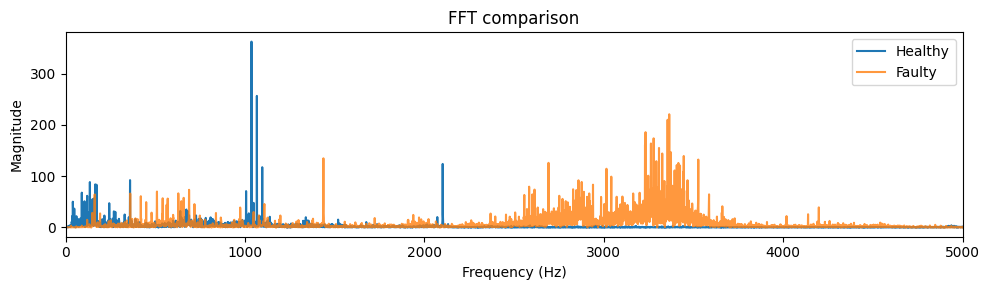

In [6]:
def plot_fft_comparison(
    healthy: CWRURecord,
    faulty: CWRURecord,
    duration_sec: float = 1.0,
):
    fs = healthy.sampling_rate_hz
    n = int(duration_sec * fs)

    def fft_mag(x):
        f = np.fft.rfftfreq(len(x), 1 / fs)
        mag = np.abs(np.fft.rfft(x))
        return f, mag

    fh, mh = fft_mag(healthy.signal[:n])
    ff, mf = fft_mag(faulty.signal[:n])

    plt.figure(figsize=(10, 3))
    plt.plot(fh, mh, label="Healthy")
    plt.plot(ff, mf, label="Faulty", alpha=0.8)
    plt.xlim(0, 5000)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("FFT comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


if healthy_records and faulty_records:
    plot_fft_comparison(healthy_records[0], faulty_records[0])


### Note 3:
Spectral analysis further confirms the physical distinction between healthy and faulty conditions. Healthy signals exhibit a structured, multi-modal spectrum with dominant energy around 1 kHz, while faulty signals show increased energy at higher frequencies (~3.3 kHz), consistent with impulsive excitations caused by bearing defects.

## Note 4: 
**Validation Summary and Decision to Proceed**

The dataset ingestion and labeling process was validated through multiple complementary analyses. 
Semantic validation confirmed consistency between file naming conventions and assigned labels. 
Statistical analysis showed clear differences between healthy and faulty signals, with faulty conditions 
exhibiting significantly higher RMS and kurtosis values. 

Time-domain inspection revealed more irregular and impulsive patterns in faulty signals. 
Spectral analysis further confirmed a physical distinction between operating conditions: healthy signals 
present a structured, multi-modal spectrum with dominant energy around 1 kHz, while faulty signals show 
increased energy at higher frequencies (approximately 3.3 kHz), consistent with impulsive excitations 
caused by bearing defects.

Based on these validations, the healthy vs faulty separation is considered reliable, and the analysis 
can safely proceed to windowing and feature extraction.


# 2. Windowing Setup

We convert long vibration signals into fixed-size windows using a sliding window strategy.

This produces samples suitable for feature extraction and model training.

Baseline configuration (aligned with common practice in vibration analysis):
- sampling rate: 12 kHz
- window size: 2048 samples (~0.17 s)
- overlap: 50%

We create a window-level dataset `(Xw, y)` where each row is a window and `y` is the file-level label
(0 = healthy, 1 = faulty) propagated to all windows from that file.


In [10]:
from typing import Tuple

def sliding_window_1d(
    x: np.ndarray,
    window_size: int,
    step_size: int,
) -> np.ndarray:
    """
    Create sliding windows from a 1D signal.

    Parameters
    ----------
    x : np.ndarray
        1D signal.
    window_size : int
        Number of samples per window.
    step_size : int
        Step between consecutive windows.

    Returns
    -------
    windows : np.ndarray
        Array of shape (n_windows, window_size).
    """
    if x.ndim != 1:
        raise ValueError("Input signal must be 1D.")
    if window_size <= 0 or step_size <= 0:
        raise ValueError("window_size and step_size must be positive.")
    if len(x) < window_size:
        return np.empty((0, window_size), dtype=np.float32)

    n_windows = 1 + (len(x) - window_size) // step_size
    windows = np.zeros((n_windows, window_size), dtype=np.float32)

    for i in range(n_windows):
        start = i * step_size
        windows[i] = x[start:start + window_size]

    return windows


def build_window_dataset(
    records: List[CWRURecord],
    window_size: int = 2048,
    overlap: float = 0.5,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Build a window-level dataset from a list of CWRU records.

    Parameters
    ----------
    records : list[CWRURecord]
        Loaded dataset records.
    window_size : int
        Number of samples per window.
    overlap : float
        Fractional overlap between consecutive windows in [0, 1).

    Returns
    -------
    Xw : np.ndarray
        Windowed signals, shape (N, window_size).
    y : np.ndarray
        Labels per window, shape (N,), 0 healthy, 1 faulty.
    group : np.ndarray
        Group id per window (record index), useful for group-aware splitting later.
    """
    if not (0.0 <= overlap < 1.0):
        raise ValueError("overlap must be in [0, 1).")

    step_size = max(1, int(window_size * (1.0 - overlap)))

    X_list: List[np.ndarray] = []
    y_list: List[np.ndarray] = []
    g_list: List[np.ndarray] = []

    for gi, r in enumerate(records):
        w = sliding_window_1d(r.signal, window_size=window_size, step_size=step_size)
        if w.shape[0] == 0:
            continue

        X_list.append(w)
        y_list.append(np.full((w.shape[0],), r.label, dtype=np.int32))
        g_list.append(np.full((w.shape[0],), gi, dtype=np.int32))

    if not X_list:
        raise ValueError("No windows were generated. Check window_size and input signal lengths.")

    Xw = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    group = np.concatenate(g_list, axis=0)

    return Xw.astype(np.float32), y.astype(np.int32), group.astype(np.int32)


In [11]:
# ---------------------------------------------------------
# Apply windowing
# ---------------------------------------------------------

# Baseline parameters
window_size = 2048
overlap = 0.5
step_size = int(window_size * (1.0 - overlap))

print("Windowing configuration:")
print(f"  fs_hz:       {fs_hz}")
print(f"  window_size: {window_size} samples (~{window_size / fs_hz:.3f} s)")
print(f"  overlap:     {overlap:.2f}")
print(f"  step_size:   {step_size} samples (~{step_size / fs_hz:.3f} s)")

Xw, y_w, group = build_window_dataset(records, window_size=window_size, overlap=overlap)

print("\nWindow-level dataset:")
print(f"  Xw shape: {Xw.shape}  (N_windows, window_size)")
unique, counts = np.unique(y_w, return_counts=True)
label_count = dict(zip(unique.tolist(), counts.tolist()))
print(f"  label counts: {label_count}  (0=healthy, 1=faulty)")

# Sanity check: ensure there are healthy windows for training
n_healthy_windows = int(np.sum(y_w == 0))
n_faulty_windows = int(np.sum(y_w == 1))
print(f"  healthy windows: {n_healthy_windows}")
print(f"  faulty windows:  {n_faulty_windows}")

if n_healthy_windows == 0:
    raise ValueError("No healthy windows found. Check labeling rules or dataset content.")

# Additional sanity checks
print("\nSanity checks:")
print(f"  Xw dtype: {Xw.dtype}")
print(f"  Any NaNs: {np.isnan(Xw).any()}")
print(f"  Any infs: {np.isinf(Xw).any()}")


Windowing configuration:
  fs_hz:       12000
  window_size: 2048 samples (~0.171 s)
  overlap:     0.50
  step_size:   1024 samples (~0.085 s)

Window-level dataset:
  Xw shape: (5886, 2048)  (N_windows, window_size)
  label counts: {0: 1652, 1: 4234}  (0=healthy, 1=faulty)
  healthy windows: 1652
  faulty windows:  4234

Sanity checks:
  Xw dtype: float32
  Any NaNs: False
  Any infs: False


## Note 5:
Window-level distribution is skewed toward faulty windows due to the underlying dataset composition; training remains healthy-only.

In [12]:
healthy_groups = group[y_w == 0]
faulty_groups = group[y_w == 1]

print("Unique groups (files) contributing windows:")
print(f"  healthy groups: {len(np.unique(healthy_groups))}")
print(f"  faulty groups:  {len(np.unique(faulty_groups))}")


Unique groups (files) contributing windows:
  healthy groups: 4
  faulty groups:  36


In [13]:
healthy_rms = np.sqrt(np.mean(Xw[y_w == 0]**2, axis=1))
faulty_rms  = np.sqrt(np.mean(Xw[y_w == 1]**2, axis=1))

print("RMS window-level stats:")
print(f"  healthy  mean={healthy_rms.mean():.4f}  std={healthy_rms.std():.4f}")
print(f"  faulty   mean={faulty_rms.mean():.4f}  std={faulty_rms.std():.4f}")


RMS window-level stats:
  healthy  mean=0.0672  std=0.0035
  faulty   mean=0.2913  std=0.1945


## Note 6: 
**Windowing Validation Summary**

Window-level analysis confirms that the sliding window strategy produces a consistent and physically meaningful dataset.
All healthy windows originate from four distinct healthy runs, while faulty windows span 36 different fault conditions,
reflecting the inherent diversity of bearing defects in the CWRU dataset.

Healthy windows exhibit stable RMS values with low variance, whereas faulty windows show significantly higher RMS
and variability, consistent with increased vibration energy and fault severity.
This validates the windowing strategy and supports its use for subsequent feature extraction and modeling.

Root Mean Square (RMS) is a fundamental descriptor in vibration analysis and represents the effective energy level of a signal.
For acceleration measurements, RMS is directly related to the intensity of dynamic forces acting on the system.
Healthy operating conditions typically exhibit low and stable RMS values, while bearing faults introduce impulsive excitations
that increase the overall vibration energy, resulting in higher RMS.

Although RMS is a powerful indicator of vibration energy, it is not sufficient on its own for reliable anomaly detection.
RMS captures the overall energy of a signal but ignores how that energy is distributed across time and frequency.
Early-stage bearing faults often manifest as weak, localized impulsive events that redistribute energy toward specific
frequency bands without significantly increasing the total energy.

As a result, healthy and faulty signals may exhibit similar RMS values while still being physically different.
Frequency-domain representations preserve this structural information and can reveal subtle changes that remain invisible
to energy-based metrics alone.

RMS measures how much energy a vibration signal contains, but not how that energy is structured — and faults are often structural before they are energetic.


# 3. Feature Extraction

In this experiment, we investigate how different feature representations impact anomaly detectability
when the detection model is kept fixed.

Three feature sets are evaluated:

- **A — Time-domain features**: statistical descriptors commonly used in vibration analysis.
- **B — Frequency-domain features**: descriptors extracted from the FFT magnitude spectrum.
- **C — Combined features**: concatenation of time- and frequency-domain features.

This setup isolates the effect of data representation from the anomaly detection algorithm itself.


## Time-domain features (A)

In [16]:
from scipy.stats import skew, kurtosis


def time_domain_features(X: np.ndarray) -> np.ndarray:
    """
    Extract time-domain statistical features from windowed signals.

    Parameters
    ----------
    X : np.ndarray
        Windowed signals, shape (N_windows, window_size)

    Returns
    -------
    F : np.ndarray
        Time-domain feature matrix, shape (N_windows, n_features)
    """
    mean = np.mean(X, axis=1)
    std = np.std(X, axis=1)
    rms = np.sqrt(np.mean(X ** 2, axis=1))
    peak = np.max(np.abs(X), axis=1)
    crest_factor = peak / (rms + 1e-12)
    skewness = skew(X, axis=1)
    kurt = kurtosis(X, axis=1, fisher=False)

    F = np.column_stack([
        mean,
        std,
        rms,
        peak,
        crest_factor,
        skewness,
        kurt,
    ])

    return F.astype(np.float32)


## Frequency-domain features (B)

In [17]:
def frequency_domain_features(
    X: np.ndarray,
    fs_hz: int,
    n_bands: int = 8,
) -> np.ndarray:
    """
    Extract frequency-domain features from windowed signals using FFT magnitude.

    Parameters
    ----------
    X : np.ndarray
        Windowed signals, shape (N_windows, window_size)
    fs_hz : int
        Sampling rate in Hz.
    n_bands : int
        Number of frequency bands for band energy features.

    Returns
    -------
    F : np.ndarray
        Frequency-domain feature matrix.
    """
    N, L = X.shape
    fft_mag = np.abs(np.fft.rfft(X, axis=1))
    freqs = np.fft.rfftfreq(L, d=1.0 / fs_hz)

    # Normalize magnitude to reduce amplitude scaling effects
    fft_mag = fft_mag / (np.sum(fft_mag, axis=1, keepdims=True) + 1e-12)

    # Spectral centroid
    centroid = np.sum(freqs * fft_mag, axis=1)

    # Spectral bandwidth
    bandwidth = np.sqrt(
        np.sum(((freqs - centroid[:, None]) ** 2) * fft_mag, axis=1)
    )

    # Spectral entropy
    spectral_entropy = -np.sum(
        fft_mag * np.log(fft_mag + 1e-12), axis=1
    )

    # Band energy features
    band_edges = np.linspace(0, freqs[-1], n_bands + 1)
    band_energy = []

    for i in range(n_bands):
        idx = (freqs >= band_edges[i]) & (freqs < band_edges[i + 1])
        band_energy.append(np.sum(fft_mag[:, idx], axis=1))

    band_energy = np.column_stack(band_energy)

    F = np.column_stack([
        centroid,
        bandwidth,
        spectral_entropy,
        band_energy,
    ])

    return F.astype(np.float32)


## Build feature sets A, B, C

In [18]:
# ---------------------------------------------------------
# Build feature sets
# ---------------------------------------------------------

F_time = time_domain_features(Xw)
F_freq = frequency_domain_features(Xw, fs_hz=fs_hz, n_bands=8)
F_combined = np.hstack([F_time, F_freq])

print("Feature set shapes:")
print(f"  Time-domain (A):      {F_time.shape}")
print(f"  Frequency-domain (B): {F_freq.shape}")
print(f"  Combined (C):         {F_combined.shape}")


Feature set shapes:
  Time-domain (A):      (5886, 7)
  Frequency-domain (B): (5886, 11)
  Combined (C):         (5886, 18)


## Sanity checks on features

In [19]:
def feature_sanity_check(F: np.ndarray, name: str) -> None:
    print(f"\n{name} sanity check:")
    print(f"  shape: {F.shape}")
    print(f"  dtype: {F.dtype}")
    print(f"  any NaNs: {np.isnan(F).any()}")
    print(f"  any infs: {np.isinf(F).any()}")
    print(f"  mean (first 5 feats): {np.mean(F, axis=0)[:5]}")
    print(f"  std  (first 5 feats): {np.std(F, axis=0)[:5]}")


feature_sanity_check(F_time, "Time-domain features (A)")
feature_sanity_check(F_freq, "Frequency-domain features (B)")
feature_sanity_check(F_combined, "Combined features (C)")



Time-domain features (A) sanity check:
  shape: (5886, 7)
  dtype: float32
  any NaNs: False
  any infs: False
  mean (first 5 feats): [0.00849479 0.2278869  0.2284151  1.337042   4.9649925 ]
  std  (first 5 feats): [0.00680255 0.19361277 0.19329621 1.4323416  2.0208468 ]

Frequency-domain features (B) sanity check:
  shape: (5886, 11)
  dtype: float32
  any NaNs: False
  any infs: False
  mean (first 5 feats): [2.3113042e+03 1.1343138e+03 5.9981260e+00 2.0041087e-01 1.4880778e-01]
  std  (first 5 feats): [7.7797211e+02 1.2589466e+02 2.0151114e-01 1.5966019e-01 1.0762572e-01]

Combined features (C) sanity check:
  shape: (5886, 18)
  dtype: float32
  any NaNs: False
  any infs: False
  mean (first 5 feats): [0.00849479 0.2278869  0.2284151  1.337042   4.9649925 ]
  std  (first 5 feats): [0.00680255 0.19361277 0.19329621 1.4323416  2.0208468 ]


## Note 6: 

Sanity checks confirm that all feature sets are numerically stable and well-conditioned.
No NaN or infinite values were observed, and all features exhibit non-zero variance.
Time-domain features capture overall vibration energy and impulsiveness, while frequency-domain
features show substantial variability related to spectral energy redistribution.
The combined representation preserves both effects and provides the richest feature space
for anomaly detection.


## Distribution of key features

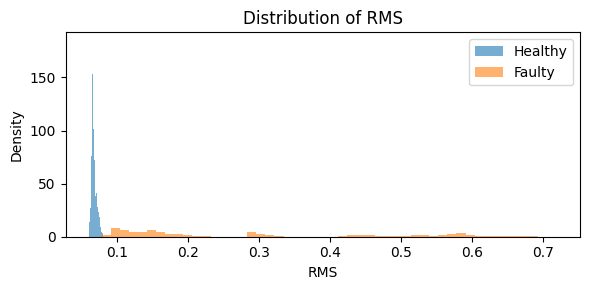

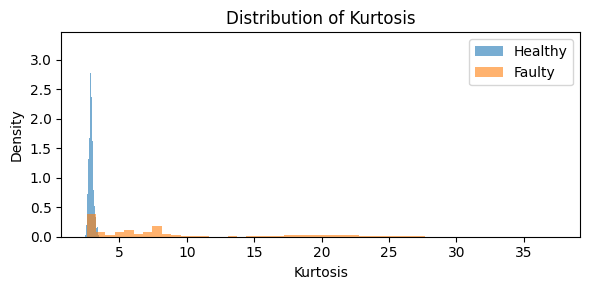

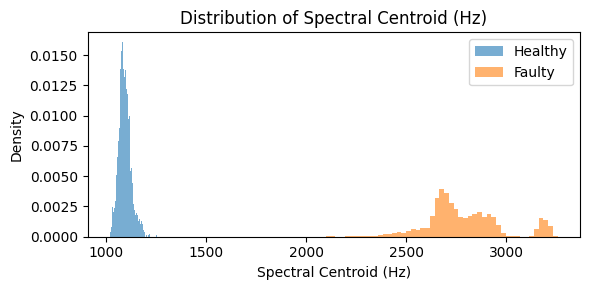

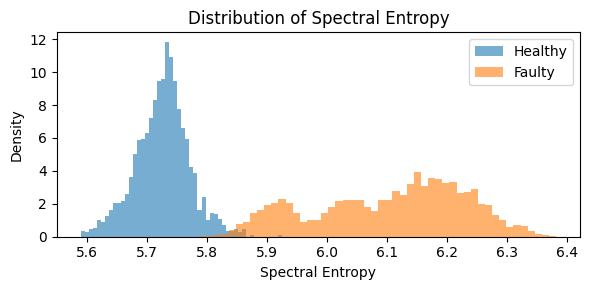

In [20]:
def plot_feature_distribution(F, y, feature_idx, feature_name):
    plt.figure(figsize=(6, 3))
    plt.hist(F[y == 0, feature_idx], bins=50, alpha=0.6, label="Healthy", density=True)
    plt.hist(F[y == 1, feature_idx], bins=50, alpha=0.6, label="Faulty", density=True)
    plt.xlabel(feature_name)
    plt.ylabel("Density")
    plt.title(f"Distribution of {feature_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Examples
plot_feature_distribution(F_time, y_w, feature_idx=2, feature_name="RMS")
plot_feature_distribution(F_time, y_w, feature_idx=6, feature_name="Kurtosis")

plot_feature_distribution(F_freq, y_w, feature_idx=0, feature_name="Spectral Centroid (Hz)")
plot_feature_distribution(F_freq, y_w, feature_idx=2, feature_name="Spectral Entropy")


## Note 7:
Feature-level distribution analysis reveals distinct and complementary behaviors across representations.

RMS provides strong separation for established faults, with minimal overlap between healthy and faulty windows.

Kurtosis, despite its sensitivity to impulsive events, exhibits substantial overlap, as healthy windows are fully
contained within the wide distribution of faulty conditions.

In contrast, spectral centroid shows near-perfect separation, with healthy windows concentrated between
1.0–1.25 kHz and faulty windows shifted toward higher frequencies (2.3–3.2 kHz), highlighting the importance
of spectral energy redistribution in bearing fault detection.

Spectral entropy provides additional, though more subtle, separation, with limited overlap.

These results demonstrate that representation choice strongly influences anomaly detectability and motivate
the use of frequency-domain and combined feature spaces for unsupervised models.


# 4. Isolation Forest — Healthy-Only Training

In this section, we train an Isolation Forest model using only healthy windows.

Faulty windows are excluded from training and used exclusively for evaluation.

To avoid data leakage, all data splits are performed at the file (group) level,
ensuring that windows from the same signal do not appear in both training and evaluation sets.

Feature scaling is fitted only on healthy training data and then applied consistently
to all splits.

The objective of this step is to analyze anomaly score distributions under different
feature representations, without yet selecting a decision threshold.


## Group-aware split (by file)

In [22]:
from sklearn.model_selection import GroupShuffleSplit


def group_train_val_test_split(
    X: np.ndarray,
    y: np.ndarray,
    groups: np.ndarray,
    train_size: float = 0.6,
    val_size: float = 0.2,
    random_state: int = 42,
):
    """
    Perform group-aware train/val/test split.

    Returns indices for train, val, and test.
    """
    gss = GroupShuffleSplit(
        n_splits=1, train_size=train_size, random_state=random_state
    )
    train_idx, temp_idx = next(gss.split(X, y, groups))

    X_temp, y_temp, g_temp = X[temp_idx], y[temp_idx], groups[temp_idx]

    val_fraction = val_size / (1.0 - train_size)
    gss2 = GroupShuffleSplit(
        n_splits=1, train_size=val_fraction, random_state=random_state
    )
    val_idx_rel, test_idx_rel = next(gss2.split(X_temp, y_temp, g_temp))

    val_idx = temp_idx[val_idx_rel]
    test_idx = temp_idx[test_idx_rel]

    return train_idx, val_idx, test_idx


## Prepare splits (healthy-only training)

In [23]:
from sklearn.preprocessing import StandardScaler

# Choose feature set for Experiment A
FEATURE_SET = "A"  # "A", "B", or "C"

if FEATURE_SET == "A":
    F = F_time
elif FEATURE_SET == "B":
    F = F_freq
elif FEATURE_SET == "C":
    F = F_combined
else:
    raise ValueError("Invalid FEATURE_SET")

# Split at group (file) level
train_idx, val_idx, test_idx = group_train_val_test_split(
    F, y_w, group, train_size=0.6, val_size=0.2
)

# Healthy-only training data
X_train = F[train_idx]
y_train = y_w[train_idx]

X_val = F[val_idx]
y_val = y_w[val_idx]

X_test = F[test_idx]
y_test = y_w[test_idx]

X_train_h = X_train[y_train == 0]

print("Split summary:")
print(f"  Train windows: {len(train_idx)} (healthy={np.sum(y_train==0)})")
print(f"  Val windows:   {len(val_idx)}")
print(f"  Test windows:  {len(test_idx)}")

if len(X_train_h) == 0:
    raise ValueError("No healthy samples in training set.")


Split summary:
  Train windows: 2941 (healthy=237)
  Val windows:   1295
  Test windows:  1650


## Feature scaling (fit on healthy only)

In [24]:
scaler = StandardScaler()
scaler.fit(X_train_h)

X_train_h_scaled = scaler.transform(X_train_h)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## Train Isolation Forest

In [25]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination=0.01,   # conservative, healthy-only assumption
    random_state=42,
    n_jobs=-1,
)

iforest.fit(X_train_h_scaled)


,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",300
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.01
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


## Anomaly score computation

In [26]:
def anomaly_score(model, X: np.ndarray) -> np.ndarray:
    """
    Convert Isolation Forest output to anomaly score.
    Higher score = more anomalous.
    """
    return -model.score_samples(X)


scores_val = anomaly_score(iforest, X_val_scaled)
scores_test = anomaly_score(iforest, X_test_scaled)

print("Anomaly score stats (validation):")
print(f"  mean={scores_val.mean():.4f}  std={scores_val.std():.4f}")
print("Anomaly score stats (test):")
print(f"  mean={scores_test.mean():.4f}  std={scores_test.std():.4f}")


Anomaly score stats (validation):
  mean=0.6880  std=0.0609
Anomaly score stats (test):
  mean=0.6629  std=0.0682


## Score distribution (sanity visualization)

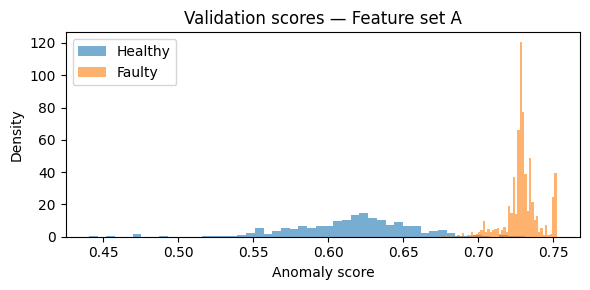

In [27]:
def plot_score_distribution(scores, y, title):
    plt.figure(figsize=(6, 3))
    plt.hist(scores[y == 0], bins=50, alpha=0.6, density=True, label="Healthy")
    plt.hist(scores[y == 1], bins=50, alpha=0.6, density=True, label="Faulty")
    plt.xlabel("Anomaly score")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_score_distribution(scores_val, y_val, f"Validation scores — Feature set {FEATURE_SET}")


## Note 8:
**Time-domain features only**

Using time-domain features only, the Isolation Forest produces partially overlapping anomaly score
distributions. 

Healthy windows exhibit a wider dispersion of scores, while faulty windows are more
concentrated at higher anomaly scores. 

A substantial overlap region remains, indicating that
energy-based and impulsiveness-related features alone are insufficient to construct a clean
geometric separation between normal and faulty behavior.

This result highlights the limitations of time-domain representations and motivates the use of
frequency-domain and combined feature spaces.
